In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

# Find scripts
sys.path.insert(0, "../src/")
from cda_scripts import *

np.random.seed(0)

%load_ext autoreload
%autoreload 2

loaded
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
# Load data
data_path = Path("../", "data")
df_raw_realized = pd.read_excel(Path(data_path,  "Realized_Schedule_20210101-20220228.xlsx"))
df_raw_future = pd.read_excel(Path(data_path, "Future_Schedule_20220301-20220331.xlsx"))

In [197]:
# Model for handling data
class DataModel():
    """
    Class for loading, processing and training ML models on Daylio exported CSV file
    """
    def __init__(self, df_raw, verbose=1):
        self.end_time = "2022-03-31"
        self.time_col = "ScheduleTime"

        self.df_raw = df_raw
        self.df_proc = None
        self.verbose = verbose

        self.X_train = None
        self.y_train = None

        self.X_valid = None
        self.y_valid = None

    def preprocess(self, cat_cols, exclude_cols, norm_cols):
        df_proc = self.df_raw.copy()
        print(f"df_raw.shape: {df_proc.shape}")
        print(df_proc.columns)

        #exclude_time = "2021-02-01"
        #df_proc = filter_exclude_time(df_proc, time_col="ScheduleTime", exclude_time=exclude_time)

        # Add counts for flight and capacity monthly
        df_proc = add_flight_counts(df_proc)

        # Add feature how close to ending date range 0-1 (1 is end date)
        df_proc = add_time_delta(df_proc, end_time=self.end_time, time_col=self.time_col)

        # Create one-hot encoded time features
        df_proc = add_date_features(df_proc, self.time_col)

        # One-hot encode other features
        cat_cols = ["Destination", "Airline", "Sector", "FlightType", "AircraftType", "FlightNumber"]
        df_proc = add_cat_features(df_proc, cat_cols)

        # Exclude columns
        exclude_cols = ["Airline", "FlightNumber"]
        df_proc = remove_columns(df_proc, exclude_cols)

        # Normalize
        norm_cols = ["SeatCapacity"]
        df_proc = normalize_minmax_cols(df_proc, norm_cols)

        self.df_proc = df_proc
        print(f"df_proc.shape: {df_proc.shape}")
        print(df_proc.columns)

    def get_trainval(self, val_months, val_year, exclude_cols):
        
        X_train, y_train, X_val, y_val = create_trainval(self.df_proc, val_months, val_year, exclude_cols)

        return X_train, y_train, X_val, y_val


In [203]:
df_raw = df_raw_realized
datamodel = DataModel(df_raw)

cat_cols = ["Destination", "Airline", "Sector", "FlightType", "AircraftType"]
exclude_cols = ["Airline", "FlightNumber"]
norm_cols = ["SeatCapacity"]
datamodel.preprocess(cat_cols, exclude_cols, norm_cols)

loaded
df_raw.shape: (39449, 9)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor'],
      dtype='object')
df_proc.shape: (39449, 1265)
Index(['ScheduleTime', 'SeatCapacity', 'LoadFactor', 'FlightCount',
       'SectorCount', 't_delta', 't_year_2021', 't_year_2022', 't_dayofweek_1',
       't_dayofweek_2',
       ...
       'FlightNumber_3665', 'FlightNumber_3704', 'FlightNumber_3721',
       'FlightNumber_3733', 'FlightNumber_3735', 'FlightNumber_3738',
       'FlightNumber_3745', 'FlightNumber_3746', 'FlightNumber_3760',
       'FlightNumber_3779'],
      dtype='object', length=1265)


In [208]:
val_months = [11]
val_year = "t_year_2021"
exclude_cols = ["ScheduleTime"]
filter_list = ["t_day$", "t_month", "t_year_2021"]
X_train, y_train, X_val, y_val = datamodel.get_trainval(val_months, val_year, exclude_cols)

fs = X_train.columns
cols = fs[fs.str.contains("Sector")]
X_train.iloc[0:20][cols]

Excluding cols in features: ['LoadFactor', 'ScheduleTime']


,SectorCount,Sector_AE,Sector_CA,Sector_CN,Sector_DK,Sector_EG,Sector_IQ,Sector_IS,Sector_MX,Sector_NL,Sector_QA,Sector_SG,Sector_US
17512,1.0,0,0,0,0,0,0,0,0,1,0,0,0
17513,2038.0,0,0,0,0,0,0,0,0,0,0,0,1
17514,2262.0,0,1,0,0,0,0,0,0,0,0,0,0
17515,2262.0,0,1,0,0,0,0,0,0,0,0,0,0
17516,2038.0,0,0,0,0,0,0,0,0,0,0,0,1
17517,2038.0,0,0,0,0,0,0,0,0,0,0,0,1
17518,2262.0,0,1,0,0,0,0,0,0,0,0,0,0
17519,2262.0,0,1,0,0,0,0,0,0,0,0,0,0
17520,2038.0,0,0,0,0,0,0,0,0,0,0,0,1
17521,2262.0,0,1,0,0,0,0,0,0,0,0,0,0


In [209]:
val_months = [11]
val_year = "t_year_2021"
exclude_cols = ["ScheduleTime"]
filter_list = ["t_day$", "t_month", "t_year_2021"]
#filter_list = ["t_day$", "t_month", "t_year_2021", "t_is_year", "t_morning", "t_night", "afternoon", "t_evening"]
#filter_list = []
X_train, y_train, X_val, y_val = datamodel.get_trainval(val_months, val_year, exclude_cols)

# Params
f = 0.15
top_n_features = 20

from sklearn.ensemble import RandomForestRegressor
max_features = int(len(X_train.columns) * f)
print("RF")
model = RandomForestRegressor(max_features=max_features, random_state=0)
model = fit_model(model, X_train, y_train, X_val, y_val)

Excluding cols in features: ['LoadFactor', 'ScheduleTime']
RF
Train: MAE: 0.041, Pearson 0.983
Valid: MAE: 0.182, Pearson 0.621
Filtered feature importance 100.0 %


/Users/maghoi/opt/anaconda3/envs/py39/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Text(0.5, 0, 'Feature importance')

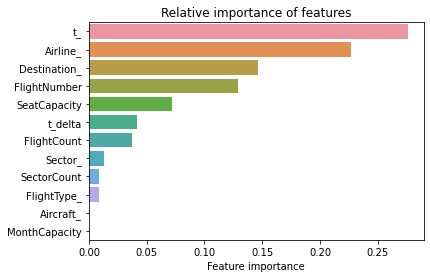

In [211]:
coef = get_coef(model, X_train)

features = ["FlightCount", "MonthCapacity","t_delta", "FlightNumber", "SeatCapacity",
            "t_", "Aircraft_", "Destination_", "Airline_",
            "FlightType_", "Sector_", "SectorCount"]
S = pd.Series(index=features)
for f in features:
    m = coef.index.str.contains(f)
    imp = np.round(coef[m].sort_values()[::-1].sum(), 3)
    S.loc[f] = imp

S_importance = S.sort_values()[::-1]

sns.barplot(x=S_importance.values, y=S_importance.index)
plt.title("Relative importance of features")
plt.xlabel("Feature importance")


Text(0.5, 0, 'Feature importance')

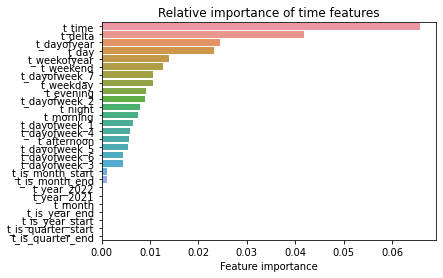

In [169]:
coef = get_coef(model, X_train)
m = coef.index.str.contains("^t_")
time = coef[m].sort_values()[::-1]
sns.barplot(x=time.values, y=time.index)
plt.title("Relative importance of time features")
plt.xlabel("Feature importance")

In [35]:
# analyze top features
exclude_cols = ["Aircraft", "Destination", "Airline"]
exclude_cols = []
print("top:\n", get_top_coef_perc(model, X_train, exclude_cols))
print("all:\n", get_coef(model, X_train))

Filtered feature importance 100.0 %
top:
 Airline_DO           3.138477e-01
SeatCapacity         7.621375e-02
t_time               6.410755e-02
t_dayofweek_7        3.011980e-02
t_delta              2.743118e-02
                         ...     
AircraftType_SU9     1.657800e-06
FlightNumber_2413    1.520831e-06
FlightNumber_501     1.023740e-06
Airline_JP           9.935277e-07
FlightNumber_650     3.896708e-07
Length: 430, dtype: float64
all:
 SeatCapacity         7.621375
t_delta              2.743118
t_year_2021          0.000000
t_year_2022          0.000000
t_dayofweek_1        0.947378
                       ...   
FlightNumber_3738    0.000000
FlightNumber_3745    0.000000
FlightNumber_3746    0.000000
FlightNumber_3760    0.002584
FlightNumber_3779    0.000000
Length: 1261, dtype: float64


In [ ]:
# Filter to subset features top n
top_n_features=500
top_features = get_coef(model, X_train).index[:top_n_features]
print(len(top_features))

X_train2, y_train2, X_val2, y_val2 = select_features(X_train, y_train, X_val, y_val, top_features)
f = 0.25
max_features = int(len(X_train2.columns) * f)
model2 = RandomForestRegressor(max_features=f, max_samples=0.70,
                                min_samples_leaf=1, min_samples_split=8)
model2 = fit_model(model2, X_train2, y_train2, X_val2, y_val2)

427
Train: MAE: 0.092, Pearson 0.897
Valid: MAE: 0.188, Pearson 0.584
Filtered feature importance 100.0 %


In [ ]:
top_n_features=20
exclude_features = get_coef(model, X_train).index[top_n_features:]

Index(['SeatCapacity', 'time_delta', 'year_2021', 'year_2022', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'dayofweek_7', 'day', 'month', 'is_month_start',
       'is_month_end', 'is_year_start', 'is_year_end', 'is_quarter_start',
       'is_quarter_end', 'Destination_AFW'],
      dtype='object')

In [ ]:
val_months = [11]
val_year = "year_2021"
exclude_cols = ["ScheduleTime"]
X_train, y_train, X_val, y_val = datamodel.get_trainval(val_months, val_year, exclude_cols)

import sklearn.linear_model as linear_model
model = linear_model.Lasso(alpha=1e-04)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
test_performance_continuous(y_pred_train, y_train, text="Train:")

y_pred_val = model.predict(X_val)
test_performance_continuous(y_pred_val, y_val, text="Valid:")

exclude_cols = ["Aircraft", "Destination", "Airline"]
exclude_cols = []
get_top_coef_perc(model, X_train, exclude_cols)

Excluding cols in features: ['LoadFactor', 'ScheduleTime']
Train: MAE: 0.132, Pearson 0.758
Valid: MAE: 0.193, Pearson 0.553


AttributeError: 'Lasso' object has no attribute 'coef'

Filtered feature importance 100.0 %


Airline_SH         2.590680e-02
Destination_DAB    2.368636e-02
Destination_YXE    2.324802e-02
Destination_YJO    2.009667e-02
Destination_RKS    1.834233e-02
                       ...     
Destination_YXH    5.060439e-05
day                4.908134e-05
Destination_DOH    2.984629e-05
Airline_OF         1.775769e-05
Sector_EG          3.817405e-07
Length: 173, dtype: float64